## Exploratory Data Analysis on Amazon Fine Food Review
### Summary
   - **Dataset Source**
       https://www.kaggle.com/snap/amazon-fine-food-reviews       
   - **Dataset Context**
       Dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
   - **Dataset Contents**
       Reviews.csv: Pulled from the corresponding SQLite table named Reviews in database.sqlite database.sqlite: Contains the table 'Reviews'
   - **Data includes**
        - Reviews from Oct 1999 - Oct 2012
        - 568,454 reviews
        - 256,059 users
        - 74,258 products
        - 260 users with > 50 reviews
   - **Acknowledgements**
       See this SQLite query for a quick sample of the dataset.
If you publish articles based on this dataset, please cite the following paper:

J. McAuley and J. Leskovec. From amateurs to connoisseurs: modeling the evolution of user expertise through online reviews. WWW, 2013.

### About the Dataset
#### Field Name
- Id - Unique Identifier
- ProductId - unique identifier for the product
- UserId - unqiue identifier for the user
- ProfileName
- HelpfulnessNumerator - number of users who found the review helpful
- HelpfulnessDenominator - number of users who indicated whether they found the review helpful
- Score - rating in the range 1 and 5, with 1 being the worse and 5 being the best
- Time - timestamp
- Summary - summary of the review
- Text - Content of the review
#### Observed facts till now
- Missing value for column with id "Summary" and "ProfileName"
- Orginal datset contain 5-star reviews (64%) of all reviews. Followed by 4-stars(14%), 1-star (9%), 3-star (8%), and finally 2-star reviews (5%).
- We have skewed dataset
- 75% of data is belonging to positive class(Score=4,5) - Imbalanced dataset
- positive reviews
    - are way more than the negative reviews.
    - are shorter
    - are found more helpful (speaks of human cognitive processing)
- Frequent reviewers
    - write longer reviews
    - more help review

### Problem Definition
The problem we are going to solve is how to help users select products which they may like and to make recommendation to stimulate sales and increase profits. Firstly, we decided to choose the Amazon Fine Food Reviews dataset which consists of 568,454 food reviews Amazon users left up to October 2012 as our dataset. Secondly, our recommendation system is based on users rating prediction. We assume that users tend to like the products that have a score of greater than 4 and we will consider the highest 5 scores product as our recommendation candidates. Thirdly, we implemented several algorithms to predict the scores of each product for each user.
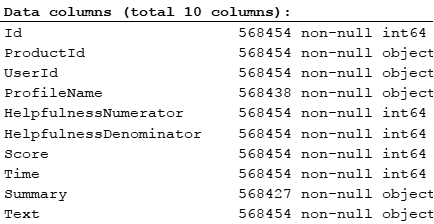

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", os.getcwd() + "\dataset"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from main import method0

def data_clean(df, feature, m):
    count = df[feature].value_counts()
    df = df[df[feature].isin(count[count > m].index)]
    return df
def data_clean_sum(df,features,m):
    fil = df.ProductId.value_counts()
    fil2 = df.UserId.value_counts()
    df['#Proudcts'] = df.ProductId.apply(lambda x: fil[x])
    df['#Users'] = df.UserId.apply(lambda x: fil2[x])
    while (df.ProductId.value_counts(ascending=True)[0]) < m or  (df.UserId.value_counts(ascending=True)[0] < m):
        df = data_clean(df,features[0],m)
        df = data_clean(df,features[1],m)
    return df

# check if it is correct


def data():
    print('loading data...')
    df = pd.read_csv(os.getcwd() + '\dataset\Reviews.csv')
    df['datetime'] = pd.to_datetime(df.Time, unit='s')
    raw_data = data_clean_sum(df, ['ProductId', 'UserId'], 10)
    # find X,and y
    raw_data['uid'] = pd.factorize(raw_data['UserId'])[0]
    raw_data['pid'] = pd.factorize(raw_data['ProductId'])[0]
    sc = MinMaxScaler()
    raw_data['time']=sc.fit_transform(raw_data['Time'].values.reshape(-1,1))
    raw_data['nuser']=sc.fit_transform(raw_data['#Users'].values.reshape(-1,1))
    raw_data['nproduct']=sc.fit_transform(raw_data['#Proudcts'].values.reshape(-1,1))
    # Sepreate the features into three groups
    X1 = raw_data.loc[:,['uid','pid']]
    X2 = raw_data.loc[:,['uid','pid','time']]
    X3 = raw_data.loc[:,['uid','pid','time','nuser','nproduct']]
    y = raw_data.Score
    # train_test split
    X1_train,X1_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,random_state=2017)
    X2_train,X2_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=2017)
    X3_train,X3_test,y_train,y_test = train_test_split(X3,y,test_size=0.3,random_state=2017)
    train = np.array(X1_train.join(y_train))
    test = np.array(X1_test.join(y_test))
    # got the productId to pid index
    pid2PID = raw_data.ProductId.unique()

    data_mixed = X1.join(y)
    total_p = data_mixed['pid'].unique().shape[0]
    total_u = data_mixed['uid'].unique().shape[0]
    # make the user-item table
    table = np.zeros([total_u,total_p])
    z = np.array(data_mixed)
    for line in z:
        u,p,s = line
        if table[u][p] < s:
            table[u][p] = s #if some one score a single thing several times
    print('the table\'s shape is:' )
    print(table.shape)
    return z, total_u,total_p,pid2PID,train,test,table,raw_data

z, total_u,total_p,pid2PID,train,test,table,raw_data = data()

loading data...
the table's shape is:
(3666, 1102)


C:\Users\mxd162430\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### Evaulation
MSE and confusion matrix

In [3]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
def caculate_mse(x):
    MSE1=[]
    MSE2=[]
    for line in train:
        u,p,s = line
        MSE1.append(s)
        MSE2.append(x[u,p])
    MSE_in_sample = mean_squared_error(MSE1,MSE2)
    MSE3=[]
    MSE4 = []
    for line in test:
        u,p,s = line
        MSE3.append(s)
        MSE4.append(x[u,p])
    MSE_out_sample = mean_squared_error(MSE3,MSE4)
    print('the in sample MSE = {} \nthe out sample MSE = {}'.format(MSE_in_sample,MSE_out_sample))
    return MSE_in_sample,MSE_out_sample


def draw_mse(method,maxIter):
    import time
    c = []
    d = []
    timetime = []
    for i in [1,2,5,7,10,20,50,70,100]:
        tic = time.time()
        data = method(factors=i,maxIter=maxIter)
        a,b = caculate_mse(data)
        c.append(a)
        d.append(b)
        toc = time.time()
        timetime.append(toc-tic)
    aa = [1, 2, 5, 7, 10, 20, 50, 70, 100]
    for i in range(len(timetime)):

        print('latent factors = {}, time = {}'.format(aa[i],timetime[i]))
    plt.figure()
    plt.plot(aa,c,label = 'in_sample_MSE')
    plt.plot(aa,d,label = 'out_sample_MSE')
    plt.xticks([1,2,5,7,10,20,50,70,100])
    plt.legend()
    plt.show()
    return 0


import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



def drawcm(y_pred,y_test =test ,title=''):
    print('caculating cm..')
    y1=[]
    y2=[]
    for line in y_test:
        u,p,s = line
        y1.append(s)
        y2.append(y_pred[u,p])
    temp1 = []
    temp2 = []
    for i in range(len(y1)):
        if np.array(y1)[i] >= 4:
            temp1.append(1)
        elif np.array(y1)[i] <= 2:
            temp1.append(0)
        else:
            temp1.append(0)
        if y2[i] >= 4:
            temp2.append(1)
        elif y2[i] <= 2:
            temp2.append(0)
        else:
            temp2.append(0)
    cm = confusion_matrix(temp1,temp2)
    plt.figure()
    plot_confusion_matrix(cm, classes=['not','recommand'], normalize=True,
                          title=title)
    plt.show()


### Randon Forest Regressor
At the very first, we try to use rfr to build a simple model. The idea is very easy, just use the algorithm find the latent score of one pair of user and item. We can see the MSE is not very high, and the confusion matrix is acceptable.

C:\Users\mxd162430\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


train MSE is (0.07106678081892767, 0.3383515866106657), test MSE is 0.3383515866106657
accrucy of recommandtion:
0.8757641695161124
accrucy of not recommandtion:
0.9788622940627915
Normalized confusion matrix
[[0.89 0.11]
 [0.13 0.87]]


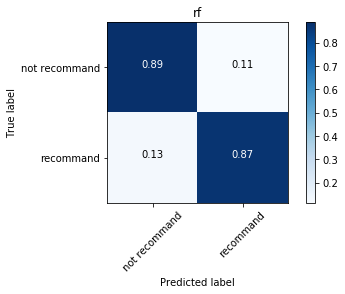

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [4]:
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.ensemble import *
def rf():
    # find X,and y
    raw_data['uid'] = pd.factorize(raw_data['UserId'])[0]
    raw_data['pid'] = pd.factorize(raw_data['ProductId'])[0]
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler()
    raw_data['time']=sc.fit_transform(raw_data['Time'].values.reshape(-1,1))
    raw_data['nuser']=sc.fit_transform(raw_data['#Users'].values.reshape(-1,1))
    raw_data['nproduct']=sc.fit_transform(raw_data['#Proudcts'].values.reshape(-1,1))

    X1 = raw_data.loc[:,['uid','pid']]
    X2 = raw_data.loc[:,['uid','pid','time']]
    X3 = raw_data.loc[:,['uid','pid','time','nuser','nproduct']]
    y = raw_data.Score

    from sklearn.model_selection import train_test_split
    X1_train,X1_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,random_state=2017)
    X2_train,X2_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=2017)
    X3_train,X3_test,y_train,y_test = train_test_split(X3,y,test_size=0.3,random_state=2017)
    a=RandomForestRegressor()
    a.fit(X3_train,y_train)
    y3 = a.predict(X3_test)
    sc = MinMaxScaler(feature_range=(1,5))
    c = mean_squared_error(y_train,a.predict(X3_train)), mean_squared_error(y_test,sc.fit_transform(y3.reshape(-1,1)))
    b = mean_squared_error(y_test,y3)
    print('train MSE is {}, test MSE is {}'.format(c,b))

    c3 = y3>=4
    t = y_test>=4
    print('accrucy of recommandtion:')
    print(accuracy_score(t,c3))
    c31 = y3<=1
    t1 = y_test<=1
    print('accrucy of not recommandtion:')
    print(accuracy_score(t1,c31))
    y_pred3 = []
    y_test3 = []
    for i in range(y3.shape[0]):
        if y3[i]>=4:
            y_pred3.append(1)
        elif y3[i]<4:
            y_pred3.append(0)
        # else:
            # y_pred3.append(1)

    for j in range(y3.shape[0]):
        if np.array(y_test)[j]>=4:
            y_test3.append(1)
        elif np.array(y_test)[j]<4:
            y_test3.append(0)
        # else:
            # y_test3.append(1)
    import itertools
    import matplotlib.pyplot as plt
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    class_names = ['not recommand','recommand']
    cnf_matrix = confusion_matrix(y_test3,y_pred3)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='rf')


    plt.show()
    return a
rf()

### Recommendation function

In [5]:
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top{} recommanded products for user {} is {}'.format(n,uid,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('the real ID is {}'.format(pid2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N

### Distance Based Model
Here we use the cosine-distance to give the similarity between vectors. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The similarity ranges from -1 to 1 where -1 means exactly opposite, 1 means exactly the same and in-between values indicating intermediate similarity or dissimilarity.
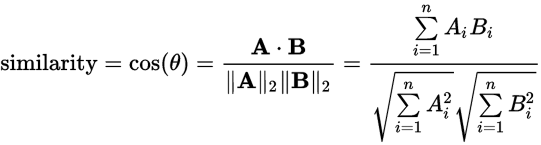

Since the MSE of traditional Collaborative Filtering model is quite high, we decided to use quasi-SVD approach instead. In this method, the output matrix is the dot product of three matrix. Here U is user similarity matrix and P is product similarity.
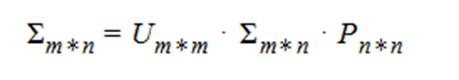

the in sample MSE = 2.1815326081122337 
the out sample MSE = 2.2582779695854387
caculating cm..
Normalized confusion matrix
[[0.42 0.58]
 [0.34 0.66]]


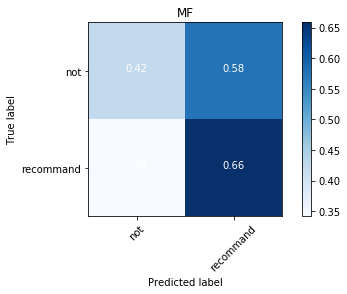

the top10 recommanded products for user 10 is [ 644  151  455   52 1072 1051  127 1067  106    0]
the real ID is ['B0058AMYTC' 'B00472I5A4' 'B0058AMY10' 'B0058AMY74' 'B001SAXPEO'
 'B006WYSFZK' 'B000G6MBUA' 'B004728MI4' 'B0012XBD7I' 'B000G6RYNE']


array([ 644,  151,  455,   52, 1072, 1051,  127, 1067,  106,    0],
      dtype=int64)

In [6]:
from sklearn.metrics.pairwise import pairwise_distances
def cf(table = table,distance = 'cosine'):
    user_similarity = pairwise_distances(table, metric=distance)
    item_similarity = pairwise_distances(table.T, metric=distance)
    sc = MinMaxScaler(feature_range=(1,5))
    a = sc.fit_transform(np.dot(user_similarity,table).dot(item_similarity))
    return a
result =cf()
caculate_mse(result)
drawcm(result,title='MF')
rec(result, 10,10,rawId= True)

The advantage is that this method is quite interpretable. However, the drawbacks are also apparent: this algorithm is naive with a deficient performance. For a large data set, this algorithm need m2+n2 times to calculate the similarity matrix.

### SVD
In our recommendation system, we have such a matrix which has many scores from the users to the items. We hope to predict the targeted users’ score to other unevaluated items and then recommend the items with the highest five scores. The advantage of SVD is that: users’ score matrix is a sparse matrix, so we can map the original data into a Low-dimensional space and then calculate the similarity of different items. This can help us reduce calculation complexity.
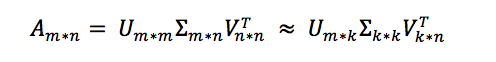

the in sample MSE = 0.3982335596954266 
the out sample MSE = 0.39813597209585755
caculating cm..
Normalized confusion matrix
[[0.96 0.04]
 [0.15 0.85]]


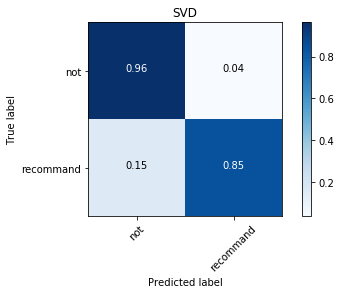

the top10 recommanded products for user 10 is [ 455 1072  216 1067  967  151  127  106 1051    0]
the real ID is ['B0058AMY10' 'B001SAXPEO' 'B000LKXBL4' 'B004728MI4' 'B000LKVD5U'
 'B00472I5A4' 'B000G6MBUA' 'B0012XBD7I' 'B006WYSFZK' 'B000G6RYNE']


array([ 455, 1072,  216, 1067,  967,  151,  127,  106, 1051,    0],
      dtype=int64)

In [7]:
from numpy import *
from scipy.sparse.linalg import svds
from numpy import linalg as la
from sklearn.preprocessing import MinMaxScaler
def svdrec(table = table, factors= 150):
    UI = matrix(table)
    # ui_df = pd.DataFrame(UI,index=table.index, columns=table.columns)
    user_ratings_mean=mean(UI,axis=0)
    user_ratings_mean=user_ratings_mean.reshape(1,-1)
    UI_demeaned=UI-user_ratings_mean
    U,sigma,Vt=svds(UI_demeaned,factors)
    sigma=diag(sigma)
    pred_mat=dot(dot(U,sigma),Vt) + user_ratings_mean
    sc=MinMaxScaler(feature_range = (1,5))
    pred_mat = sc.fit_transform(pred_mat)
    # prediction_df=pd.DataFrame(pred_mat,index=table.index,columns=table.columns)
    return pred_mat
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top{} recommanded products for user {} is {}'.format(n,uid,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('the real ID is {}'.format(pid2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N
result1 =svdrec(factors=150)
caculate_mse(result1)
drawcm(result1,title='SVD')
rec(result1, 10,10,rawId= True)

### Matrix Factorization
Latent factor models are an alternative approach that tries to explain the ratings by characterizing both items and users on, say, 20 to 100 factors inferred from the ratings patterns. For products, the discovered factors might measure obvious dimensions such as candy vs drinks, or adult food vs children’s; For users, each factor measures how much the user likes the product that score high on the corresponding movie factor. Using latent factor model, we transform the way to calculate the similarity of users and products. The features become more stable and condense.

we first create two new metrics, user-latent_factor and product-latent_factor. The size are qf and pf, p, q are the total number of users and products, f is the number of latent factors. So, every element in the target matrix can be calculate as: And the target matrix is shown as . Next, we need to create the objective function based on least-square method to minimize the loss:
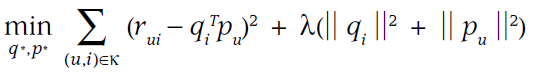

The system adjusts the model by fitting the previously observed ratings. However, the goal is to generalize those previous ratings in a way that predicts the unknown ratings. Thus, the system should avoid overfitting the observed data by regularizing the learned parameters by adding L2 term. The constant λ controls the extent of regularization and is usually determined by cross-validation. Next, we use stochastic gradient descent to optimize the objective function. The processing is:
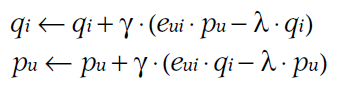

Where gamma is the stochastic learning rate and e is the error term. In the iteration, when the change in loss is larger than 0, the learning rate increases by 5%; if delta-loss is smaller than 0, it means the new loss is becoming larger. The learning rate decreases by 50% so that the loss can converge.

iter = 1, loss = 3301.7404045701987, delta_loss = -3301.7404045701987, LR = 0.02
iter = 2, loss = 958.3923993288948, delta_loss = 2343.348005241304, LR = 0.01
iter = 3, loss = 622.1707286423499, delta_loss = 336.22167068654494, LR = 0.0105
iter = 4, loss = 574.0879123559447, delta_loss = 48.082816286405205, LR = 0.011025000000000002
iter = 5, loss = 539.7005151837731, delta_loss = 34.38739717217163, LR = 0.011576250000000003
iter = 6, loss = 504.59235138766473, delta_loss = 35.10816379610833, LR = 0.012155062500000004
iter = 7, loss = 465.1733180593014, delta_loss = 39.419033328363355, LR = 0.012762815625000005
iter = 8, loss = 422.151716948773, delta_loss = 43.021601110528366, LR = 0.013400956406250006
iter = 9, loss = 377.95182805804455, delta_loss = 44.19988889072846, LR = 0.014071004226562506
iter = 10, loss = 334.83808338199907, delta_loss = 43.113744676045485, LR = 0.014774554437890632
iter = 11, loss = 294.37866392045623, delta_loss = 40.459419461542836, LR = 0.01551328215978516

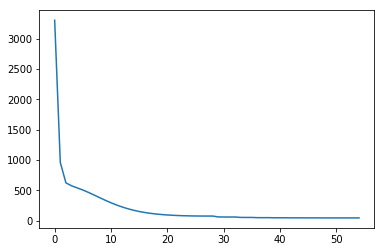

the in sample MSE = 0.035408886677129624 
the out sample MSE = 0.03384597831571721
caculating cm..
Normalized confusion matrix
[[0.99 0.01]
 [0.14 0.86]]


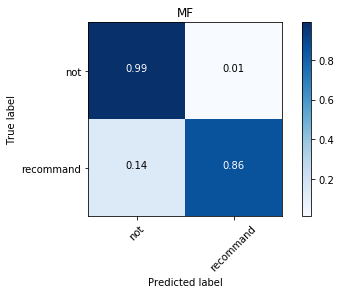

the top10 recommanded products for user 10 is [ 996   80  448  155 1093   96  243  182  201  256]
the real ID is ['B004HOLD60' 'B001EQ4P2I' 'B001LNTY70' 'B001EQ4RBM' 'B004HOSGWE'
 'B004HOLD92' 'B001KVPBS4' 'B004HOLD4W' 'B001EQ4QJK' 'B004HOQE64']


array([ 996,   80,  448,  155, 1093,   96,  243,  182,  201,  256],
      dtype=int64)

In [8]:
def MF1(data=z, factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=False):
    # initial the latent matrix for user and item
    P = np.random.rand(total_u, factors) / 3
    Q = np.random.rand(total_p, factors) / 3
    # initial y as the history of loss
    y = []
    # initial the iteration and last loss
    iteration = 0
    last_loss = 0
    while iteration < maxIter:
        loss = 0
        for i in range(data.shape[0]):
            # get the uid,pid and the score from every line
            u, p, s = data[i]
            # calculate the error
            error = s - np.dot(P[u], Q[p])
            # calculate the loss function
            # avoid loss become to large, scale to 1/50
            loss += error ** 2 / 50
            # update the parameter according to the gradient descent
            pp = P[u]
            qq = Q[p]
            P[u] += LRate * error * qq
            Q[p] += LRate * error * pp
        iteration += 1
        y.append(loss)
        delta_loss = last_loss - loss
        print('iter = {}, loss = {}, delta_loss = {}, LR = {}'.format(iteration, loss, delta_loss, LRate))
        # update the learn rate to make sure it will converge
        if abs(last_loss) > abs(loss):
            LRate *= 1.05
        else:
            LRate *= 0.5
        # When converge, stop the gradient descend
        if abs(delta_loss) < abs(GD_end):
            print('the diff in loss is {}, so the GD stops'.format(delta_loss))
            break
        last_loss = loss
    if plot:
        plt.plot(y)
        plt.show()
    return P.dot(Q.T)

result =MF1( factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=1)
caculate_mse(result)
drawcm(result,title='MF')
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top{} recommanded products for user {} is {}'.format(n,uid,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('the real ID is {}'.format(pid2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N
rec(result, 10,10,rawId= True)

The MF gives a very good prediction: the train set MSE is 0.03542 and the test set MSE is 0.03385. While both MSEs are equally small, thus no overfitting problem occurs.
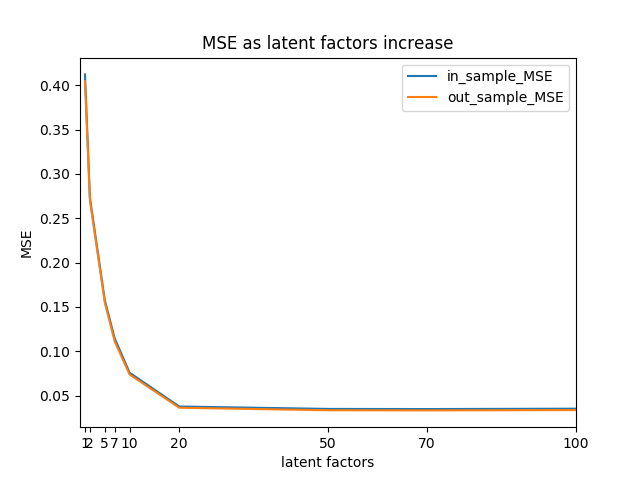
As the number of latent factors increase, the MSE decreases. And MSE converges around n=20.

### Probabilistic Matrix Factorization

PMF is similar to MF. It is nothing more than a MF assuming the distribution of user and production are Gaussian. That is:
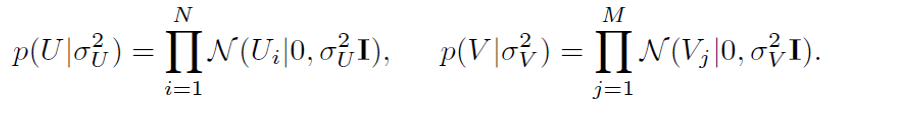

And the joint distribution of user and product is the distribution of the scores.
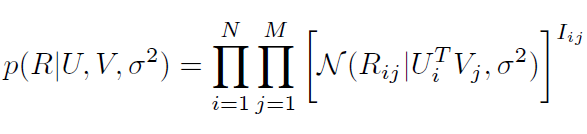

The problem comes to maximum the probability of U, V based on R and variance. This transformation is based on Bayesian formula. Rewrite the function above and applying log to both sides:
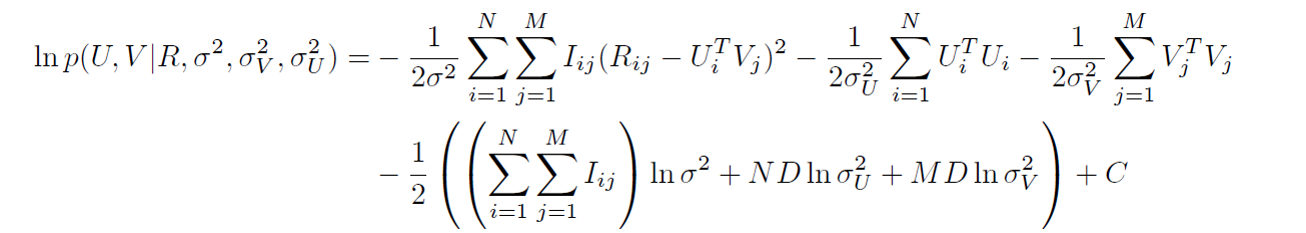

When optimizing this function, the standard errors are fixed, so the objective function is:
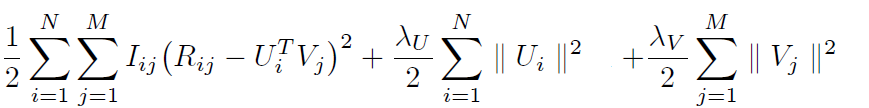
Gradient descent process is the same with basic MF. PMF does better than MF for sparse matrices. The assumption of Gaussian makes it more accurate to predict. But for our dataset, the chosen data is not sparse, so the performance of PMF is almost the same with MF.

iter = 1, loss = 3481.11113738092, delta_loss = -3381.11113738092, LR = 0.02
iter = 2, loss = 1109.484359554629, delta_loss = 2371.626777826291, LR = 0.01
iter = 3, loss = 790.2402531192095, delta_loss = 319.24410643541955, LR = 0.0105
iter = 4, loss = 745.7591822756605, delta_loss = 44.48107084354899, LR = 0.011025000000000002
iter = 5, loss = 715.5705680656234, delta_loss = 30.18861421003703, LR = 0.011576250000000003
iter = 6, loss = 685.6858162076549, delta_loss = 29.88475185796858, LR = 0.012155062500000004
iter = 7, loss = 652.1146486693557, delta_loss = 33.571167538299164, LR = 0.012762815625000005
iter = 8, loss = 614.6277276338074, delta_loss = 37.486921035548335, LR = 0.013400956406250006
iter = 9, loss = 574.9806214342194, delta_loss = 39.64710619958794, LR = 0.014071004226562506
iter = 10, loss = 535.3403278287035, delta_loss = 39.64029360551592, LR = 0.014774554437890632
iter = 11, loss = 497.5225804390311, delta_loss = 37.81774738967238, LR = 0.015513282159785164
iter = 1

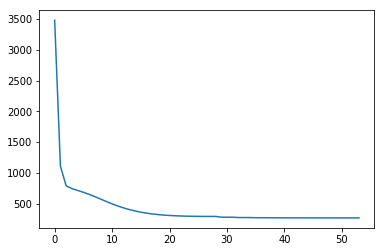

the in sample MSE = 0.0378055997715261 
the out sample MSE = 0.03637200643150455
caculating cm..
Normalized confusion matrix
[[0.99 0.01]
 [0.19 0.81]]


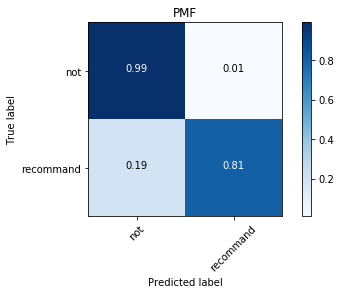

the top10 recommanded products for user 10 is [ 15 858 739 456 512 606 190 969 233 196]
the real ID is ['B0034KP00S' 'B000EVIDWW' 'B004NSH6O8' 'B000ZSX4GE' 'B000H7LVKY'
 'B005QRPHSW' 'B005QRPH78' 'B000HDK0DC' 'B000XQ5HDQ' 'B005QRPHPU']


array([ 15, 858, 739, 456, 512, 606, 190, 969, 233, 196], dtype=int64)

In [9]:
def PMF(data=z, factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, regU = 0.01 ,regI = 0.01 ,plot=False):
    P = np.random.rand(total_u, factors) / 3
    Q = np.random.rand(total_p, factors) / 3
    y = []
    iteration = 0
    last_loss = 100
    while iteration < maxIter:
        loss = 0
        for i in range(data.shape[0]):
            u, p, s = data[i]
            error = s - np.dot(P[u], Q[p])
            loss += error ** 2/50
            pp = P[u]
            qq = Q[p]
            P[u] += LRate *  (error * qq - regU*pp)
            Q[p] += LRate * (error * pp - regI * qq)
        loss += regU*(P*P).sum() +regI*(Q*Q).sum()
        iteration += 1
        y.append(loss)
        delta_loss = last_loss - loss
        print('iter = {}, loss = {}, delta_loss = {}, LR = {}'.format(iteration, loss, delta_loss, LRate))
        if abs(last_loss) > abs(loss):
            LRate *= 1.05
        else:
            LRate *= 0.5

        if abs(delta_loss) < abs(GD_end):
            print('the diff in loss is {}, so the GD stops'.format(delta_loss))
            break
        last_loss = loss
    if plot:
        plt.plot(y)
        plt.show()
    return P.dot(Q.T)
result =PMF( factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=1)
caculate_mse(result)
drawcm(result,title='PMF')
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top{} recommanded products for user {} is {}'.format(n,uid,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('the real ID is {}'.format(pid2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N
rec(result, 10,10,rawId= True)

### Conclusion
We can find that the MF and PMF did a good job. And the recommendtion they make are also very reasonable.